## Note this model has an RMSE of ~\$19,326 on the combined public and private test set 

In [14]:
import pandas as pd
pd.set_option('max_columns', 99)
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from IPython.display import HTML
from sklearn.linear_model import LinearRegression , Lasso, LassoCV
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import seaborn as sns 


In [15]:
pd.set_option('max_columns', 100)

In [16]:
train = pd.read_csv('../data/ames_train.csv')
test = pd.read_csv('../data/ames_test.csv')

In [17]:
train.head(3)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000


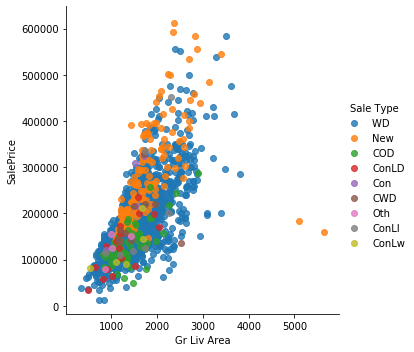

In [18]:
### this is your EDA / cleaning / vis 

sns.lmplot(x='Gr Liv Area', y='SalePrice', data=train, hue='Sale Type', fit_reg=False);


In [19]:
## drop extreme values 

train = train.loc[train['Gr Liv Area'] < 4500].copy()

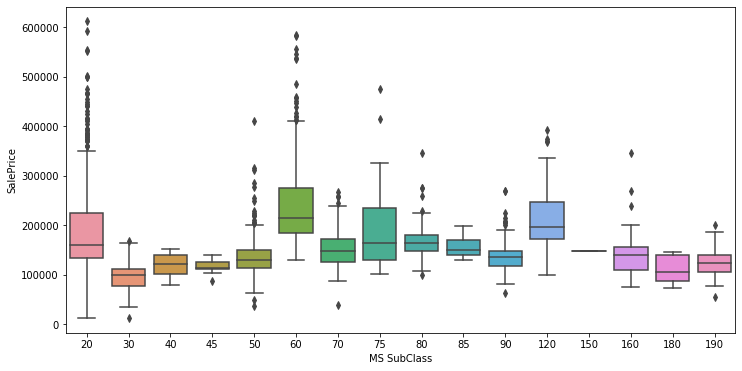

In [20]:
## quick eda for ms subclass 

fig , ax = plt.subplots(figsize=(12,6))
sns.boxplot(x='MS SubClass', y='SalePrice', data=train, ax=ax);

In [21]:
def clean_data(dfin):
    df = dfin.copy()
    ### use to map numeric values onto all the quality columns 
    qual_dict = {'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4}

    df['MS SubClass'] = df['MS SubClass'].astype(str)

    ## just getting list of column names 
    ordinal_col_names = [col for col in df.columns if (col[-4:] in ['Qual', 'Cond']) and col[:3] != 'Ove']
    ## creating a new feature
    df['Years Old'] = df.apply(lambda row: row['Yr Sold'] - max(row['Year Built'], row['Year Remod/Add']), axis=1)
    ## I want to dummy this column 
    df['Date Sold'] = df.apply(lambda row: str(row['Mo Sold'])+ '-' + str(row['Yr Sold']), axis=1)
    df.loc[:,df.dtypes!= 'object'] = df.loc[:, df.dtypes != 'object'].apply(lambda col: col.fillna(col.mean()))
    
    ## transforming columns 
    df[ordinal_col_names] = df[ordinal_col_names].applymap(lambda cell: 2 if pd.isnull(cell) else qual_dict[cell])
    
    return df

In [22]:
train = clean_data(train)

In [23]:
## for imputing lot frontage 
lot_frontage_dict = train.groupby('Neighborhood')['Lot Frontage'].mean().to_dict()
lot_frontage_dict['GrnHill'] = train['Lot Frontage'].mean()
lot_frontage_dict['Landmrk'] = train['Lot Frontage'].mean()

In [24]:
## imputing lot frontage by neighborhood where it is missing 
def fill_lot_frontage(df):
    df['Lot Frontage'] = df.apply(lambda row: lot_frontage_dict[row['Neighborhood']] if pd.isnull(row['Lot Frontage']) else row['Lot Frontage'], axis=1)
    return df

train = fill_lot_frontage(train)

In [25]:
## want object columns where at least 80% of the homes have data 
dum_filter = (train.dtypes == 'object') & (train.isnull().mean() < .2)

dummies_train = pd.get_dummies(train.loc[:, dum_filter], dummy_na=True)

In [27]:
cols_to_drop = [ 'Id',
                'PID',
                #'MS SubClass',
                'Mo Sold',
                'SalePrice']


num_df = train.loc[:, (train.dtypes != 'object') & (train.isnull().mean() < .2)].drop\
(columns = cols_to_drop)

In [28]:
numeric_features = num_df.columns

In [29]:
X_train = pd.concat([num_df, dummies_train], axis=1)
y_train = train['SalePrice']

In [30]:
## scale the data 
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)

In [31]:
lasso_cv = LassoCV(n_alphas=1000, cv=5)

## fitting to the log of sale price 
lasso_cv.fit(X_train_sc, np.log1p(y_train))

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=1000, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [32]:
test = clean_data(test)
test = fill_lot_frontage(test)

In [33]:
dummies_test = pd.get_dummies(test.loc[:, dum_filter], dummy_na=True)

In [34]:
#### adding column of zeros for dummy columns not created in the test dataframe 
train_not_test = set(dummies_train.columns) - set(dummies_test.columns)
for i in train_not_test:
    test[i] = 0 

In [35]:
## this df has all columns in the test
test_modeling_big = pd.concat([test, dummies_test], axis=1)

In [36]:
## this df just contains the features my model was trained on 
test_modeling_final =  test_modeling_big[X_train.columns]

In [37]:
## make predictions on the scaled data 
predictions = lasso_cv.predict(ss.transform(test_modeling_final))

In [38]:
## just for ease of submitting predictions
original_test =  pd.read_csv('../data/ames_test.csv')
original_test['SalePrice'] = np.expm1(predictions)

In [39]:
submission =  original_test[['Id', 'SalePrice']]

In [40]:
submission.to_csv('./submission01_08.csv', index=False)

In [41]:
#submission = pd.read_csv('./submissions/10_3_Lasso_trimmed.csv')
submission.columns = ['Id', 'SalePrice']

full_data = pd.read_csv('../data/amesfull.csv', index_col='Unnamed: 0')

## Merge the submission df to the full data 
results = full_data[['Order', 'SalePrice']].merge(submission, left_on='Order', \
                                          right_on='Id', suffixes=('_Actual', '_Predicted'))

### SalePrice_Actual is our "y_test" here 
results['Residuals'] = results['SalePrice_Actual'] - results['SalePrice_Predicted']
results['Squared_Residuals'] = results['Residuals'] ** 2

## residuals over 90K on the test data 
results.loc[results['Residuals'].abs()> 90_000,:].sort_values\
('Squared_Residuals', ascending=False) # largest residual homes 

,Order,SalePrice_Actual,Id,SalePrice_Predicted,Residuals,Squared_Residuals
296,957,375000,957,473875.650442,-98875.650442,9.776394e+09
117,373,82500,373,177185.384287,-94685.384287,8.965322e+09
430,1408,260000,1408,168165.737897,91834.262103,8.433532e+09


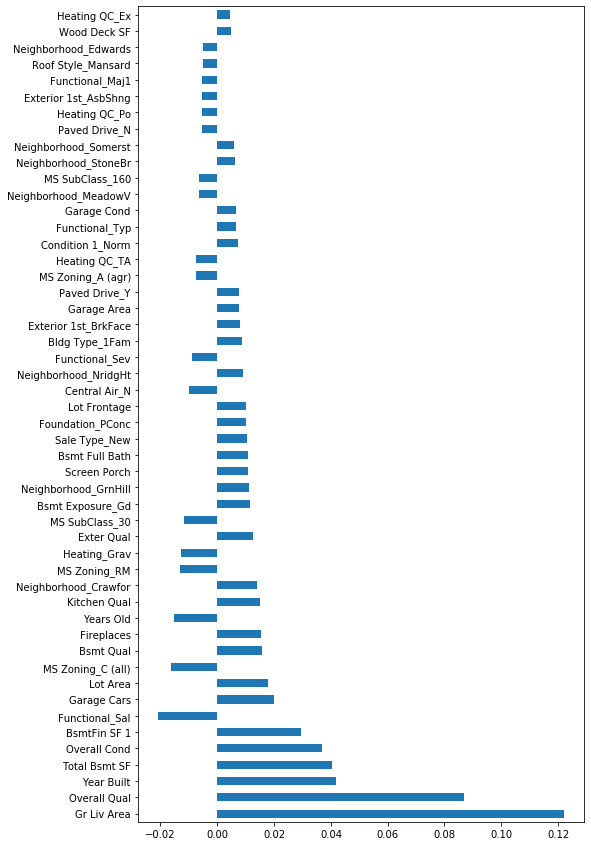

In [42]:
### looking at a lot of coefs - these are making sense 

fig , ax = plt.subplots(figsize=(8, 15))

coef_df = pd.concat([pd.DataFrame(lasso_cv.coef_, index=X_train.columns, columns=['Coef']), \
           pd.DataFrame(abs(lasso_cv.coef_), index=X_train.columns, columns=['ABS'])], axis=1)

coef_df.sort_values('ABS', ascending=False)['Coef'].head(50).plot.barh(ax = ax);

In [43]:
total_cols = len(lasso_cv.coef_)
cols_used = sum(abs(lasso_cv.coef_) > 0)

print(f'Total possible features: {total_cols}')
print(f'Features actually used {cols_used}\n')
print(f'This means lasso zeroed out {total_cols - cols_used} features')

Total possible features: 344
Features actually used 103

This means lasso zeroed out 241 features


In [44]:
### RMSE on all test results (both public and private)

results['Squared_Residuals'].mean() ** .5

19325.61576843948

In [45]:
### visually inspecting homes that I missed by at least $80,000

test[test['Id'].isin(results[results['Residuals']> 80_000]['Id'].values)]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,...,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Years Old,Date Sold,Heating QC_Po,Exterior 1st_ImStucc,Condition 2_RRNn,Electrical_Mix,Functional_Sev,Neighborhood_Landmrk,MS Zoning_A (agr),Neighborhood_GrnHill,Heating_OthW,Heating_Wall,Condition 2_RRAn,Exterior 2nd_Stone,Utilities_NoSeWa,MS SubClass_150,Condition 2_PosN,Exterior 1st_CBlock,Functional_Sal,Condition 2_Artery,Roof Matl_Membran,Condition 2_RRAe,Exterior 1st_Stone
230,1408,905426030,30,RL,85.0,19550,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,1940,2007,Flat,Tar&Grv,PreCast,PreCast,None,0.0,2,2,PConc,2,2,Gd,ALQ,1035,Unf,0,545,1580,GasA,Ex,Y,SBrkr,1518,0,0,1518,1,0,...,1,1,5,Typ,2,Gd,NaN,1976.759904,NaN,0,0,2,2,Y,0,39,0,0,0,0,NaN,NaN,NaN,0,1,2008,WD,1,1-2008,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
250,2246,911370450,120,RM,59.0,5568,Pave,NaN,IR1,HLS,AllPub,Inside,Mod,Crawfor,Norm,Norm,TwnhsE,1Story,8,5,2006,2007,Hip,CompShg,CemntBd,CmentBd,Stone,473.0,3,2,PConc,3,2,Gd,GLQ,1573,Unf,0,0,1573,GasA,Gd,Y,SBrkr,1625,0,0,1625,1,1,...,1,3,5,Typ,1,Gd,Attchd,2006.000000,Fin,2,495,2,2,Y,123,0,0,0,153,0,NaN,NaN,NaN,0,10,2007,New,0,10-2007,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
422,1946,535355020,70,RL,113.0,21281,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,2Story,5,4,1935,2007,Gable,CompShg,Wd Sdng,MetalSd,None,0.0,2,2,BrkTil,2,1,No,Unf,0,Unf,0,666,666,GasA,Gd,Y,SBrkr,1308,1778,0,3086,0,0,...,1,3,9,Min1,0,NaN,BuiltIn,2007.000000,Unf,3,1200,2,2,Y,0,208,290,0,156,0,NaN,NaN,NaN,0,11,2007,WD,0,11-2007,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
793,92,533130130,60,RL,85.0,13143,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,1993,1993,Gable,CompShg,HdBoard,ImStucc,BrkFace,504.0,3,2,PConc,3,2,No,LwQ,250,GLQ,981,0,1231,GasA,Ex,Y,SBrkr,1251,1098,0,2349,1,0,...,1,3,9,Typ,1,TA,Attchd,1993.000000,RFn,3,762,2,2,Y,32,130,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,17,6-2010,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Need plotly for the below to run 

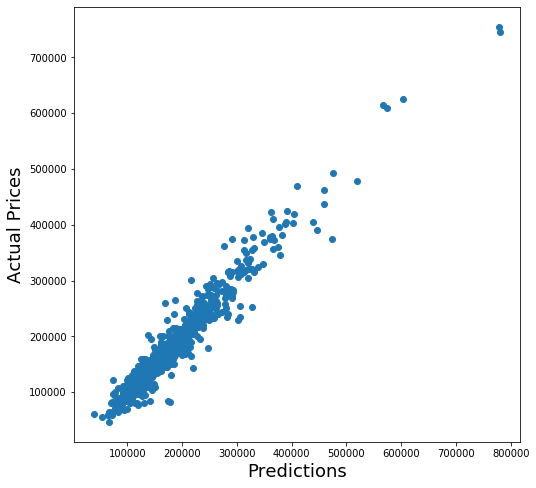

In [46]:
import chart_studio.plotly as py
import plotly.graph_objs as go

import squarify

ten_largest = results.sort_values('Squared_Residuals', ascending=False).set_index('Order')['Squared_Residuals'].head(10)
other_869 = results.sort_values('Squared_Residuals', ascending=False).iloc[10:]['Squared_Residuals'].sum()
total_error = results['Squared_Residuals'].sum()

ten_largest = results.sort_values('Squared_Residuals', ascending=False).set_index('Order')['Squared_Residuals'].head(10)
other_869 = results.sort_values('Squared_Residuals', ascending=False).iloc[10:]['Squared_Residuals'].sum()

fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(results['SalePrice_Predicted'], results['SalePrice_Actual'])
ax.set_xlabel('Predictions', fontsize=18)
ax.set_ylabel('Actual Prices', fontsize=18);

In [47]:
trace = go.Scatter(x= results['SalePrice_Predicted'], y=results['Residuals'],\
                  mode= 'markers', hovertext='ID: ' + results['Order'].astype(str), \
                  hoverinfo='text')

layout = go.Layout(xaxis= {'title':{'text':'Predictions', 'font':{'size':18}}}, 
                  yaxis={'title':{'text':'Residuals', 'font':{'size':18}}})

fig = {'data':[trace], 'layout':layout}

py.iplot(fig , filename='scatter-bm', fileopt='overwrite')

In [48]:
### whole bunch of plotting code 

ten_largest.index = ["ID: " + str(i) for i in ten_largest.index]

final_series = ten_largest.append(pd.Series(other_869, index=['Other 869']) )
final_series = final_series.sort_values()

x = 0.
y = 0.
width = 100.
height = 100.

values = list(final_series.values)

normed = squarify.normalize_sizes(values, width, height)
rects = squarify.squarify(normed, x, y, width, height)
pcts = [str(i)+'%' for i in((.5 - ((final_series / (final_series[-1]*2))))+.45)*100]

color_brewer = [f'hsl(205.0, 55.0%, {pct})' for pct in pcts]
shapes = []
annotations = []
counter = 0

for r in rects:
    shapes.append( 
        dict(
            type = 'rect', 
            x0 = r['x'], 
            y0 = r['y'], 
            x1 = r['x']+r['dx'], 
            y1 = r['y']+r['dy'],
            line = dict( width = 2 ),
            fillcolor = color_brewer[counter]
        ) 
    )
    annotations.append(
        dict(
            x = r['x']+(r['dx']/2),
            y = r['y']+(r['dy']/2),
            text = final_series.index[counter],
            showarrow = False
        )
    )
    counter = counter + 1
    if counter >= len(rects):
        counter = 0

# For hover text
trace0 = go.Scatter(
    x = [ r['x']+(r['dx']/2) for r in rects ], 
    y = [ r['y']+(r['dy']/2) for r in rects ],
    text = [ str(round((v / total_error *100), 2))+'% of total error' for v in values ], 
    mode = 'text',
)
        
layout = dict(
    title = f'RMSE = {round(results["Squared_Residuals"].mean()**.5)}',
    height=900, 
    width=900,
    xaxis=dict(showgrid=False,zeroline=False),
    yaxis=dict(showgrid=False,zeroline=False),
    shapes=shapes,
    annotations=annotations,
    hovermode='closest'
)

# With hovertext
figure = dict(data=[trace0], layout=layout)

# Without hovertext
# figure = dict(data=[Scatter()], layout=layout)

py.iplot(figure, filename='squarify-treemap')